In [64]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole

IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = 200,200

In [51]:
smi_file='NIST_Si_100.txt'

In [73]:
tms = Chem.MolFromSmarts('[Si]([CH3])([CH3])[CH3]')

def is_derivatized(m):
    return m.HasSubstructMatch(tms)

def remove_derivatization_groups(m):
    return AllChem.DeleteSubstructs(m,tms)

def add_derivatiztion_grous(m):
    pass
    

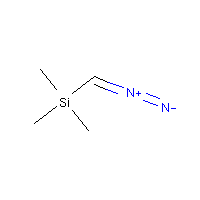

In [79]:
test_smi='C[Si](C)(C)C=[N+]=[N-]'
test_m = Chem.MolFromSmiles(test_smi)
test_m

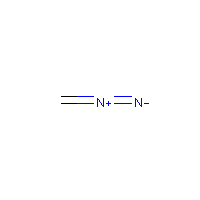

In [80]:
test_n = remove_derivatization_groups(test_m)
test_n

In [76]:
mols={}
with open(smi_file) as f:
    for smi in f:
        m = Chem.MolFromSmiles(smi)
        if m: mols[smi.rstrip()] = m
        

In [77]:
print("# total:", len(mols))
print("# derivatized:", sum(map(is_derivatized,mols.values())))

# total: 62
# derivatized: 16


In [78]:
noderiv = {}
for smi in mols.keys():
    if is_derivatized(mols[smi]):
        n = remove_derivatization_groups(mols[smi])
        noderiv[Chem.MolToSmiles(n)] = n
        print(smi,"=>", Chem.MolToSmiles(n))
    else:
        noderiv[smi] = mols[smi]

C[SiH](C)C => 
C[Si](C)(C)C => 
C[Si](C)(C)O => O
C[Si](C)(C)F => F
C[Si](C)(C)C#C => C#C
C[Si](C)(C)C#N => C#N
C[Si](C)(C)C=C => C=C
CC[Si](C)(C)C => CC
C[Si](C)(C)[Si] => [Si]
C[Si](C)(C)CO => CO
CO[Si](C)(C)C => CO
C[Si](C)(C)Cl => Cl
CC#C[Si](C)(C)C => C#CC
C[Si](C)(C)CC#C => C#CC
C[Si](C)(C)C=C=C => C=C=C
C[Si](C)(C)C=[N+]=[N-] => C=[N+]=[N-]
